In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
from spectral_networks.nn.models import ReLUNet
from spectral_networks.nn.cplx.models import BispectralEmbedding
from transform_datasets.patterns.synthetic import *
from transform_datasets.transforms import *
from transform_datasets.utils.wandb import load_or_create_dataset
from torch_tools.trainer import Trainer
from torch_tools.logger import WBLogger
from torch_tools.config import Config
from torch_tools.regularizer import Regularizer, MultiRegularizer
from torch_tools.functional import l1_norm

from torch_tools.data import TrainValLoader
from pytorch_metric_learning import losses, distances
from torch.optim import Adam

from torch_tools.plotter import Plotter, MultiPlotter
from spectral_networks.analysis.wandb import gen_avg_data_spectrum_plot_1D, gen_UVW_analysis_plots_1D
from spectral_networks.analysis.wandb import gen_avg_data_spectrum_plot_2D, gen_UVW_analysis_plots_2D

In [36]:
DATA_PROJECT = "dataset"
MODEL_PROJECT = "bispectrum"
ENTITY = "naturalcomputation"
DEVICE = "cpu"
SEED = 0

"""
DATASET
"""

dataset_config = Config(
    {
        "type": HarmonicsS1,
        "params": {"dim": 256, "n_classes": 10, "seed": 5},
    }
)

transforms_config = {
    "0": Config(
        {
            "type": CyclicTranslation1D,
            "params": {
                "fraction_transforms": 1.0,
                "sample_method": "linspace",
            },
        }
    ),
    "1": Config(
        {
            "type": UniformNoise,
            "params": {"n_samples": 1, "magnitude": 0.1},
        }
    ),
}


tdataset_config = {"dataset": dataset_config, "transforms": transforms_config}

dataset = load_or_create_dataset(tdataset_config, DATA_PROJECT, ENTITY)

"""
DATA_LOADER
"""

data_loader_config = Config(
    {
        "type": TrainValLoader,
        "params": {
            "batch_size": 32,
            "fraction_val": 0.2,
            "num_workers": 1,
            "seed": SEED,
        },
    }
)

data_loader = data_loader_config.build()
data_loader.load(dataset)

In [46]:
BispectralEmbedding?

In [53]:
"""
MODEL
"""
model_config = Config(
    {
        "type": BispectralEmbedding,
        "params": {
            "size_in": dataset.dim,
            "hdim": 256,
            "seed": SEED,
            "device": DEVICE
        },
    }
)
model = model_config.build()

"""
OPTIMIZER
"""
optimizer_config = Config({"type": Adam, "params": {"lr": 0.001}})
# optimizer = optimizer_config.build()


'''
REGULARIZER
'''
regularizer_config1 = Config({'type': Regularizer, 'params': {'function': l1_norm, 
                                              'variables': ['out'],
                                              'coefficient': 0.1
                                             }
                         })

regularizer_config2 = Config({'type': Regularizer, 'params': {'function': l1_norm, 
                                              'variables': ['out'],
                                              'coefficient': 1
                                             }
                         })

multiregularizer_config = Config({'type': MultiRegularizer, 'params': {'regularizer_configs': [regularizer_config1, regularizer_config2]}})
regularizer = multiregularizer_config.build()


"""
LOSS
"""
loss_config = Config(
    {
        "type": losses.ContrastiveLoss,
        "params": {
            "pos_margin": 0,
            "neg_margin": 1,
            "distance": distances.LpDistance(),
        },
    }
)
loss = loss_config.build()

"""
MASTER CONFIG
"""

config = {
    "dataset": dataset_config,
    "model": model_config,
    "optimizer": optimizer_config,
    "loss": loss_config,
    "data_loader": data_loader_config,
}

'''
PLOTTER
'''
plotter_config1 = Config({'type': Plotter, 'params': {'function': gen_UVW_analysis_plots_1D, 
                                              'variables': ['model'],
                                              'f_params': {'use_wandb': True}
                                             }
                         })


plotter_config2 = Config({'type': Plotter, 'params': {'function': gen_avg_data_spectrum_plot_1D, 
                                              'variables': ['train_data'],
                                              'f_params': {'use_wandb': True},
                                              'tag': 'train'
                                             }
                         })

plotter_config3 = Config({'type': Plotter, 'params': {'function': gen_avg_data_spectrum_plot_1D, 
                                              'variables': ['val_data'],
                                              'f_params': {'use_wandb': True},
                                              'tag': 'val'
                                             }
                         })

multiplotter_config = Config({'type': MultiPlotter, 'params': {'plotter_configs': [plotter_config2, plotter_config3]}})
plotter = multiplotter_config.build()

step_plotter = plotter_config1.build()

"""
LOGGING
"""
logging_config = Config(
    {
        "type": WBLogger,
        "params": {
            "config": config,
            "project": MODEL_PROJECT,
            "entity": ENTITY,
            "log_interval": 10,
            "watch_interval": 10 * len(data_loader.train),
            "end_plotter": plotter,
            "step_plotter": step_plotter
        },
    }
)

logger = logging_config.build()


/Users/sophia/opt/anaconda3/envs/py3/lib/python3.8/site-packages/torch/nn/modules/container.py:569: UserWarning:

Setting attributes on ParameterDict is not supported.



wandb: wandb version 0.12.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [54]:
"""
TRAINER
"""

training_config = Config(
    {
        "type": Trainer,
        "params": {
            "model": model,
            "loss": loss,
            "logger": logger,
            "regularizer": regularizer,
            "device": DEVICE,
            "optimizer_config": optimizer_config,
        },
    }
)

trainer = training_config.build()

Epoch 0 ||  N Examples 0 || Train Total Loss 1453.69202 || Validation Total Loss 284.84784
Epoch 1 ||  N Examples 2560 || Train Total Loss 151.50165 || Validation Total Loss 91.54741
Epoch 2 ||  N Examples 5120 || Train Total Loss 62.82146 || Validation Total Loss 50.63039


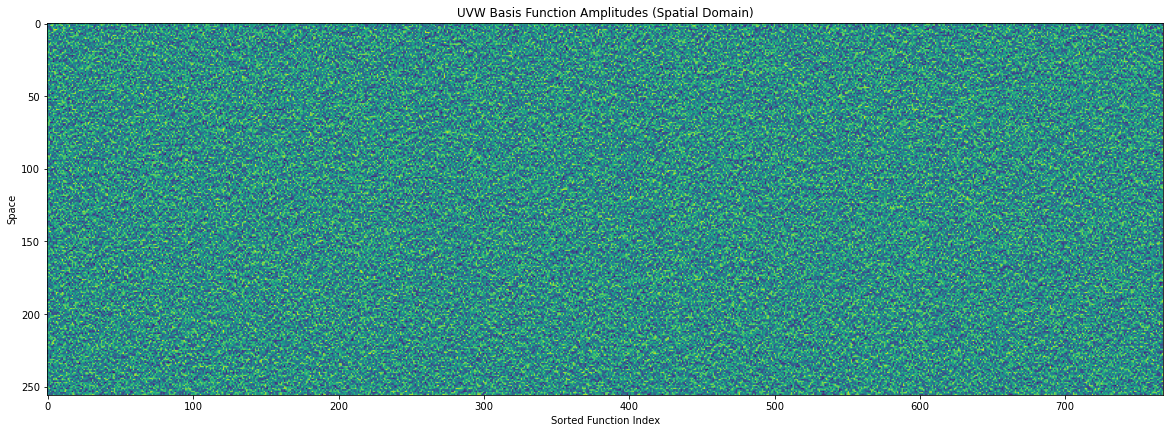

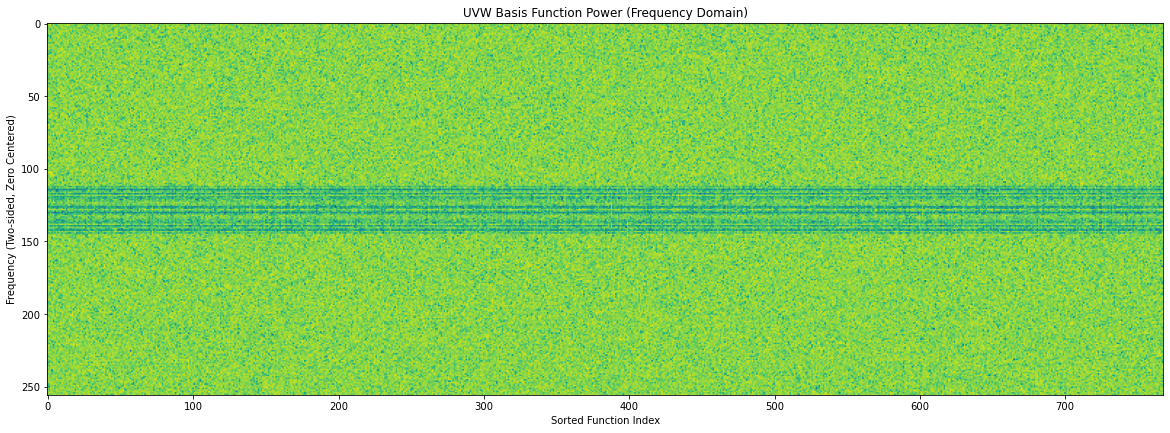

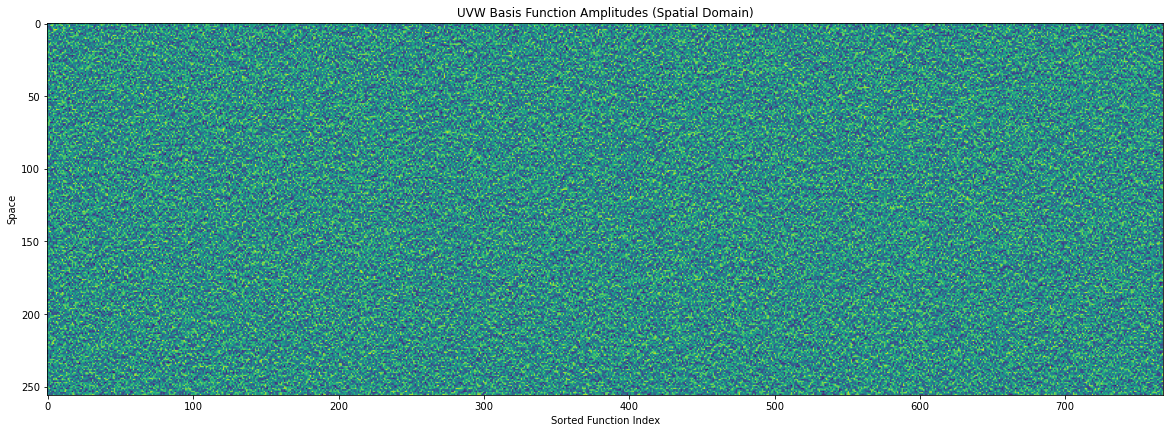

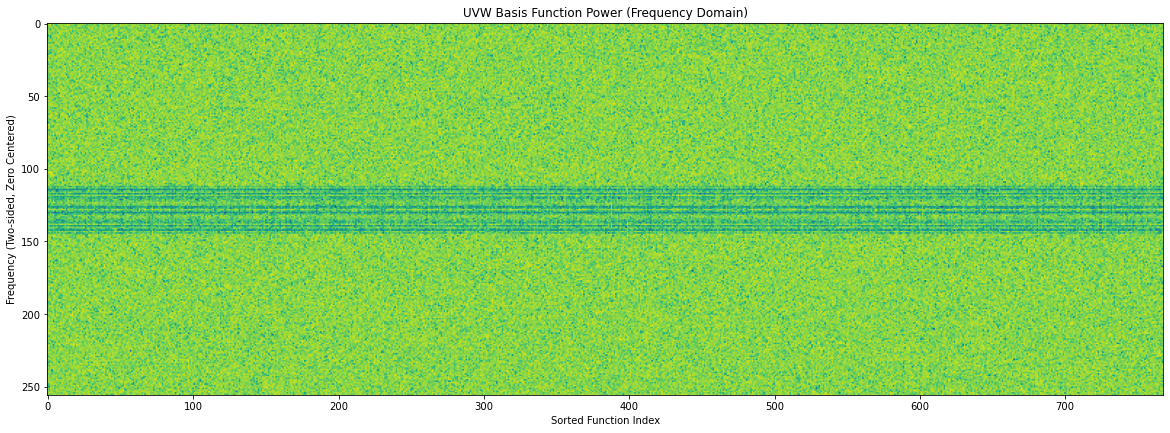

In [55]:
trainer.train(data_loader, epochs = 2)

In [56]:
trainer.resume(data_loader, epochs=10)

wandb: wandb version 0.12.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f9851201940>
Traceback (most recent call last):
  File "/Users/sophia/opt/anaconda3/envs/py3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/Users/sophia/opt/anaconda3/envs/py3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1297, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/Users/sophia/opt/anaconda3/envs/py3/lib/python3.8/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/Users/sophia/opt/anaconda3/envs/py3/lib/python3.8/multiprocessing/popen_fork.py", line 44, in wait
    if not wait([self.sentinel], timeout):
  File "/Users/sophia/opt/anaconda3/envs/py3/lib/python3.8/multiprocessing/connection.py", line 933, in wait
    return [key.fileobj for (key, events) in ready]
  File "/Users/sophia/opt/anaconda3/envs/py3/lib/python3.8/selectors.py", 

Stopping and saving run at epoch 2
